<h1>Modeling and Control of an Intracardiac Catheter</h1>
<p>Daniel Newman <br>
<a href="mailto:danielnewman09@gmail.com">danielnewman09@gmail.com</a> <br>
<a href="http://danielnewman09.github.io">http://danielnewman09.github.io</a> <br>

This notebook demonstrates the entire modeling and control process for the intracardiac catheter problem. Its structure is generally broken down as follows:

1. Define necessary functions to calculate forces and rotate elements into a global coordinate frame
2. Define and generate a model based on user-defined parameters
3. Define and generate the response of this model using PD control
4. Plot the responses
5. Create and show an animation demonstrating the motion of the model

In [1]:
#import autograd.numpy as np
#from autograd import grad
#from autograd import jacobian
from sympy import symbols
from sympy.physics import mechanics
from sympy.physics.mechanics import dynamicsymbols
import sympy.physics.mechanics as me
from sympy.physics.mechanics import inertia
from scipy import integrate
from sympy import Dummy, lambdify
from scipy.integrate import odeint
from sympy import Matrix
from scipy.optimize import minimize
import numpy as np
import cvxpy as cvx
import control

In [2]:
import crawlab_toolbox.utilities as craw_utils
import crawlab_toolbox.plotting as plot

%matplotlib inline
# We will use matplotlib to 
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import writers

In [3]:
def body_rotation(coords,angle):
    def R_z(theta):
        rotation = np.zeros([len(theta),2,2])
        rotation[:,0,0] = np.cos(theta)
        rotation[:,0,1] = -np.sin(theta)
        rotation[:,1,0] = np.sin(theta)
        rotation[:,1,1] = np.cos(theta)
        return rotation

    rotated_coords = np.matmul(R_z(angle[:]), coords)
    
    x = rotated_coords[:,0,0]
    y = rotated_coords[:,1,0]

    return x,y


def get_xy_coords(n,p, L):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)

    lengths = np.concatenate([np.broadcast_to(L / n,n)])
    zeros = np.zeros(p.shape[0])[:, None]

    x = np.hstack([zeros])
    y = np.hstack([zeros])

    for i in range(0,n):

        x_app,y_app = body_rotation(np.array([[lengths[i]],[0]]),p[:,i])
        x = np.append(x,np.atleast_2d(x_app).T,axis=1)
        y = np.append(y,np.atleast_2d(y_app).T,axis=1)

    return np.cumsum(x, 1), np.cumsum(y, 1)

def get_xy_deriv(n,p, L):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)

    lengths = np.concatenate([np.broadcast_to(L / n,n)])
    zeros = np.zeros(p.shape[0])[:, None]

    x_dot = np.hstack([zeros])
    y_dot = np.hstack([zeros])

    for i in range(0,n):

        x_app = -lengths[i] * np.sin(p[:,i]) * p[:,i + (n)]
        y_app = lengths[i] * np.cos(p[:,i]) * p[:,i + (n)]

        x_dot = np.append(x_dot,np.atleast_2d(x_app).T,axis=1)
        y_dot = np.append(y_dot,np.atleast_2d(y_app).T,axis=1)

 
    return np.cumsum(x_dot, 1), np.cumsum(y_dot, 1)

In [4]:
def force(coords,r,time):
    ''' Get the force resulting from steady flow on a cylinder in two dimensions'''
    
    flow_amp = 0.5
    
    # Flow field velocity
    u_y = flow_amp * np.cos(1. * np.pi * time) + flow_amp # m/s
    
    #  Drag coefficient
    Cd = 1.2 
    
    # Mass density of blood
    rho_blood = 1060 # kg/m^3
    
    # Diameter of the catheter
    Diam = 2.667e-3 # m
    
    # Length projected into the X-axis
    projected_length = r[0]
    
    # Drag force
    F_dy = 0.5 * u_y * rho_blood * Cd * Diam * projected_length
    
    # Ignoring forces in the x-direction for now
    f_x = 0.

    return np.array([[f_x],[F_dy]])

def get_forces(n,q,L,time=0.):
    
    x,y = get_xy_coords(n,q,L)

    # For each origin point of each link, integrate the cross product of the 
    # position vector for the link with the  force converted into the link frame.
    # Return the torques in a way that can be added to the state variables when
    # integrating

    tau = np.zeros(n)
    
    L = L / n

    for i in range(n):
        
        angles = np.atleast_2d(q[i])

        frame_origin = np.array([[x[0,i]],
                                 [y[0,i]]])

        # Direction vector pointing along the X-direction of the desired link
        # This vector is defined in the global coordinate frame
        r = np.array([[x[0,i] - x[0,i-1]],
                      [y[0,i] - y[0,i-1]]])

        # Unit vector pointing in the direction aligned with the link
        # This vector is divided by L, which is the magnitude of r
        u = r / L
        
        # Get the projected force on the element at position "x"
        proj_force = lambda x: body_rotation(force(x * u + frame_origin,r,time),-angles)
        
        # Compute the torque applied by the force at position "x"
        torquez = lambda x: np.cross(np.array([x,0]),np.array([proj_force(x)]).flatten())
        
        # The total torque applied to the element is the integral of the torque
        # across its length
        torques = np.array([integrate.quad(torquez,0,L)[0]])

        tau[i] = torques
        
        
    return tau

In [5]:
def derive_sys(n,p):
    """Derive the equations of motion using Kane's method"""
    #-------------------------------------------------
    # Step 1: construct the catheter model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))
    
    # Torques applied to each element due to external loads
    Torque = dynamicsymbols('tau:{0}'.format(n))
    
    # Force applied at the end of the catheter by the user
    F_in = dynamicsymbols('F:{0}'.format(1))

    # Unpack the system values
    M, L, E, I, G, J = p
    
    # Structural damping 
    damp = 0.05

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # time symbol
    t = symbols('t')
    
    # The stiffness of the internal springs simulating material stiffness
    stiffness = E * I
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A,0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []
    
    # Create a rotated reference frame for the first rigid link
    Ar = A.orientnew('A' + str(0), 'axis', [q[0],A.z])

    # Create a point at the center of gravity of the first link
    Gr = P.locatenew('G' + str(0),(l[0] / 2) * Ar.x)
    Gr.v2pt_theory(P,A,Ar)
    
    # Create a point at the end of the link
    Pr = P.locatenew('P' + str(0), l[0] * Ar.x)
    Pr.v2pt_theory(P, A, Ar)   

    # Create the inertia for the first rigid link
    Inertia_r = inertia(Ar,0,0,m[0] * l[0]**2 / 12)

    # Create a new particle of mass m[i] at this point
    Par = mechanics.RigidBody('Pa' + str(0), Gr, Ar, m[0], (Inertia_r,Gr))
    particles.append(Par)
    
    # Add an internal spring based on Euler-Bernoulli Beam theory
    forces.append((Ar, -stiffness * (q[0]) / (l[0]) * Ar.z))
    
    # Add a damping term
    forces.append((Ar, (-damp * u[0]) * Ar.z))
    
    # Add a new ODE term
    kinetic_odes.append(q[0].diff(t) - u[0])
    
    P = Pr
    
    for i in range(1,n):
        
        # Create a reference frame following the i^th link
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i],Ar.z])
        Ai.set_ang_vel(A, u[i] * Ai.z)
        
        # Set the center of gravity for this link
        Gi = P.locatenew('G' + str(i),l[i] / 2 * Ai.x)
        Gi.v2pt_theory(P,A,Ai)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)
        
        # Set the inertia for this link
        Inertia_i = inertia(Ai,0,0,m[i] * l[i]**2 / 12)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.RigidBody('Pa' + str(i), Gi, Ai, m[i], (Inertia_i,Gi))
        particles.append(Pai)
        
        # The external torques influence neighboring links
        if i + 1 < n:
            next_torque = 0
            for j in range(i,n):
                next_torque += Torque[j]
        else:
            next_torque = 0.
        forces.append((Ai,(Torque[i] + next_torque) * Ai.z))
        
        # Add another internal spring
        forces.append((Ai, (-stiffness * (q[i] - q[i-1]) / (2 * l[i])) * Ai.z))
        
        # Add the damping term
        forces.append((Ai, (-damp * u[i]) * Ai.z))

        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi
    
    # Add the user-defined input at the tip of the catheter, pointing normal to the 
    # last element
    forces.append((P, F_in[0] * Ai.y))

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations( particles, forces)

    return KM, fr, fr_star, q, u, Torque, F_in, l, m

In [6]:
def linearize_system(n,kane,p):

    # Unpack the system values
    M, L, E, I, G, J = p

    KM, fr, fr_star, q, u, Torque, F_in, l, m = kane

    lengths = np.concatenate([np.broadcast_to(L / n,n)])    
    masses = np.concatenate([np.broadcast_to(M / n,n)])

    # Fixed parameters: lengths, and masses
    parameters = list(l) + list(m)
    parameter_vals = list(lengths) + list(masses)
    
    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u + tau + list(force_in)]
    unknown_dict = dict(zip(q + u + tau + list(force_in), unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # This will be done outside of the for loop to speed up computation
    linearizer = KM.to_linearizer()
    Maz, A, B = linearizer.linearize()
    
    op_point = dict()
    constants = dict()

    for h in range(n):
        op_point[q[h]] = 0.0
        op_point[u[h]] = 0.0

    for k in range(n):
        constants[l[k]] = lengths[k]
        constants[m[k]] = masses[k]
    
    M_op = me.msubs(Maz, op_point)
    A_op = me.msubs(A, op_point)
    B_op = me.msubs(B, op_point)
    perm_mat = linearizer.perm_mat
    M_op = me.msubs(M_op,constants)
    A_op = me.msubs(A_op,constants)
    B_op = me.msubs(B_op,constants)

    A_lin = perm_mat.T * M_op.LUsolve(A_op)
    B_lin = perm_mat.T * M_op.LUsolve(B_op)
    A_sol = A_lin.subs(op_point).doit()
    B_sol = B_lin.subs(op_point).doit()

    A_np = np.array(np.array(A_sol), np.float)
    B_np = np.array(np.array(B_sol), np.float)

    return A_np,B_np

In [7]:
n = 5

M = 1
L = 1
E = 10e-3
I = 1
G = 0.5
J = 1


theta0_z = 0.

theta0dot_z = 0.

thetad_z = 50.
thetaddot_z = 0.

tau_max = 1
StartTime = 0. 
dt = 0.01
tmax = 10.
t = np.arange(0,tmax,dt)

X0 = np.array([theta0_z,theta0dot_z])
XD = np.array([thetad_z,thetaddot_z])
Distance = np.deg2rad(XD - X0)

p = [M, L, E, I, G, J]

In [8]:
Kane = derive_sys(n,p)
KM, fr, fr_star, q, u, tau, force_in, l, m = Kane

In [9]:
A,B = linearize_system(n,Kane,p)

In [10]:
lengths = np.concatenate([np.broadcast_to(L / n,n)])    
masses = np.concatenate([np.broadcast_to(M / n,n)])

# Fixed parameters: lengths, and masses
parameters = list(l) + list(m)
parameter_vals = list(lengths) + list(masses)

In [11]:
# define symbols for unknown parameters
unknowns = [Dummy() for i in q + u + tau + list(force_in)]
unknown_dict = dict(zip(q + u + tau + list(force_in), unknowns))
kds = KM.kindiffdict()

In [12]:
# substitute unknown symbols for qdot terms
mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

In [13]:
# create functions for numerical calculation 
mm_func = lambdify(unknowns + parameters, mm_sym)
fo_func = lambdify(unknowns + parameters, fo_sym)

In [14]:
def get_response(n,Kane,p,optimize=False,use_control=True):
    KM, fr, fr_star, q, u, tau, force_in, l, m = Kane
    
    tau_max, StartTime, dt, t, X0, Distance, L = p
   
    q_i = np.array(X0[:n])
    u_i = np.array(X0[n:])

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.concatenate([np.tile(q_i,n),np.tile(u_i,n)])
    
    tau = np.zeros(n)
    
    y_d = craw_utils.s_curve(t,0.5,2.5,StartTime=0.)
    
    # function which computes the derivatives of parameters
    def gradient(x, currtime, parameter_vals,t_sys,tau,force_in):
        
        if use_control:
            curr_x,curr_y = get_xy_coords(n,x,L)
            curr_x_dot,curr_y_dot = get_xy_deriv(n,x,L)
            y_ref = np.interp(currtime,t_sys,y_d)
            force_in[0] = 10. * (y_ref - curr_y[0,-1]) + 5 * (0 - curr_y_dot[0,-1])
        else:
            force_in[0] = 0.
        
        tau = get_forces(n,x,L,currtime)

        vals = np.concatenate((x, tau, force_in, parameter_vals))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))

        return np.array(sol).T[0]

    return odeint(gradient, y0, t, args=(parameter_vals,t,tau, force_in))

In [15]:
def linear_response(n,A,B,p,
             Shaper='Unshaped',
             optimize=False,motion='Step',
             Disturbance=None,
             use_control=True):
    
    tau_max, StartTime, dt, t, X0, Distance, L = p

    q_i = np.array(X0[:n])
    u_i = np.array(X0[n:])

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.concatenate([np.tile(q_i,n),np.tile(u_i,n)])
    
    tau = np.zeros(n)
    
    y_d = craw_utils.s_curve(t,0.5,5,StartTime=0.)

    time_now = 0.
    
    u = np.zeros(B.shape[1])

    # function which computes the derivatives of parameters
    def gradient(x, currtime, t_sys):

        if use_control:
            curr_x,curr_y = get_xy_coords(n,x,L)
            curr_x_dot,curr_y_dot = get_xy_deriv(n,x,L)
            y_ref = np.interp(currtime,t_sys,y_d)
            y_ref = 0.0
            u[0] = 10. * (y_ref - curr_y[0,-1]) + 5 * (0 - curr_y_dot[0,-1])
        else:
            u[0] = 0.
        
        tau = get_forces(n,x,L,currtime)
        
        u[1:] = tau[1:]
       
        sol = np.matmul(A,x) + np.matmul(B,u)#+ get_forces(n,x,L)
        
        #pdb.set_trace()

        return np.array(sol)

    return odeint(gradient, y0, t, args=((t,)))

In [16]:
def get_mpc_response(n,A,B,p,
             Shaper='Unshaped'):
    tau_max, StartTime, DT, TIME, X0, Distance, L = p
    B_input = np.atleast_2d(B[:,0]).T
    B_disturbance = np.atleast_2d(B[:,1:])
    
    prediction_horizon = 20
    prediction_dt = 0.05

    prediction_time = np.arange(0,tmax + prediction_dt,prediction_dt)

    num_samples = tmax / prediction_dt # Determine the number of samples in the sim time

    C = np.eye(2*n)
    D = np.zeros((2*n,1))
    
    
    sys_disturb = control.ss(A, B_disturbance, C, np.zeros((2*n,B_disturbance.shape[1])))
    sys = control.ss(A, B_input, C, np.zeros((2*n,B_input.shape[1])))

    # Get the number of states and inputs - for use in setting up the optimization
    # problem
    num_states = np.shape(A)[0] # Number of states
    num_inputs = np.shape(B_input)[1] # Number of inputs
    
    print('Number of Inputs: {}'.format(num_inputs))
    print('Number of Samples: {}'.format(num_samples))


    # Convert the system to digital. We need to use the discrete version of the 
    # system for the MPC solution
    digital_sys = control.sample_system(sys, prediction_dt)
    digital_sys_disturb = control.sample_system(sys_disturb, prediction_dt)

    Q_y = 1000.
    Q_yd = 0

    R = 10

    # Convert the system to digital. We need to use the discrete version of the 
    # system for the MPC solution
    digital_sys = control.sample_system(sys, prediction_dt)    

    q_i = np.array(X0[:n])
    u_i = np.array(X0[n:])

    # initial positions and velocities – assumed to be given in degrees
    x0 = np.concatenate([np.tile(q_i,n),np.tile(u_i,n)])
    u0 = np.array([0.])
    
    tau = np.zeros(n)
    
    x_d = 0.0
    
    x_total = np.array([x0]).T  
    u_total = np.zeros(1,)
    tip_y_total = np.zeros(1,)
    tip_x_total = np.zeros(1,)
    cost_total = np.zeros(1,)
    
    # Form the variables needed for the cvxpy solver
    x = cvx.Variable(int(num_states), int(prediction_horizon)+1)
    u = cvx.Variable(int(num_inputs), int(prediction_horizon))

    trig_tol = 0.001
    
    # Now, we work through the range of the simulation time. At each step, we
    # look prediction_horizon samples into the future and optimize the input over
    # that range of time. We then take only the first element of that sequence
    # as the current input, then repeat.
    for i in range(int(num_samples)):

        states = []
        for t in range(prediction_horizon):
            tau = get_forces(n,x0,L,prediction_time[i] + prediction_time[t])
            
            u_increment = u[:,t] - u_total[-1]
            
            cost =  (Q_y * cvx.sum_squares(x_d - sum(lengths * (np.sin(np.floor(x0[:n] / trig_tol) * trig_tol) + (np.cos(np.floor(x0[:n] / trig_tol) * trig_tol) * (x[:n,t] - np.floor(x0[:n] / trig_tol) * trig_tol))))) +
                     Q_yd * cvx.sum_squares(0. - sum(lengths * x[n:,t+1] * np.cos(np.floor(x0[:n] / trig_tol) * trig_tol))) + 
                    # To control for x-displacement: 
                    #(Q_y * cvx.sum_squares(x_d - sum(lengths * (np.cos(np.floor(x0[:n] / trig_tol) * trig_tol) - (np.sin(np.floor(x0[:n] / trig_tol) * trig_tol) * (x[:n,t+1] - np.floor(x0[:n] / trig_tol) * trig_tol))))) + 
                    # Q_yd * cvx.sum_squares(0. + sum(lengths * x[n:,t+1] * np.sin(np.floor(x0[:n] / trig_tol) * trig_tol))) + 
                    R * cvx.sum_squares(u_increment))
            
            constr = [x[:,t+1] == digital_sys.A * x[:, t] + digital_sys.B * u[:, t] + np.matmul(digital_sys_disturb.B,tau[1:]).T,
                      cvx.norm(u[:,t], 'inf') <= tau_max]
            states.append(cvx.Problem(cvx.Minimize(cost), constr))

        states.append(cvx.Problem(cvx.Minimize(cost), constr))
        
        # sums problem objectives and concatenates constraints.
        prob = sum(states)
        #prob.constraints += [sum(lengths * (np.sin(np.floor(x0[:n] / trig_tol) * trig_tol) + (np.cos(np.floor(x0[:n] / trig_tol) * trig_tol) * (x[:n,-1] - np.floor(x0[:n] / trig_tol) * trig_tol)))) == x_d]
        prob.constraints += [x[:,0] == x0]
        prob.solve(solver=cvx.ECOS)
        
        u_total = np.append(u_total, u[0].value)
        x_total = np.append(x_total,np.array(x[:,1].value),axis=1)
        
        current_cost = Q_y * np.square(x_d - np.sum((lengths * (np.sin(np.floor(x0[:n] / trig_tol) * trig_tol) + (np.cos(np.floor(x0[:n] / trig_tol) * trig_tol) * (np.array(x[:n,1].value).flatten() - np.floor(x0[:n] / trig_tol) * trig_tol))))))
                    
        # Finally, save the current state as the initial condition for the next
        x0 = np.array(x[:,1].value.A.flatten())
        
        curr_x,curr_y = get_xy_coords(n,x0,L)
        
        tip_x_total = np.append(tip_x_total,curr_x[:-1])
        tip_y_total = np.append(tip_y_total,curr_y[:,-1])
        
        cost_total = np.append(cost_total,current_cost)
    
    sampling_multiple = prediction_dt / DT

    sampling_offset = np.ones(int(sampling_multiple),)

    u_newDt = np.repeat(u_total, sampling_multiple)
    u_newDt = u_newDt[int(sampling_multiple):]
    
    x_total_new = np.repeat(x_total, sampling_multiple,axis=1).T
    x_total_new =x_total_new[int(sampling_multiple):,:]
    
    cost_total_new = np.repeat(cost_total,sampling_multiple)
    cost_total_new = cost_total_new[int(sampling_multiple):]
    
    u = np.zeros(B.shape[1])
    
    x0 = np.concatenate([np.tile(q_i,n),np.tile(u_i,n)])

    # Convert the system to digital using the faster sampling rate.
    #new_digital_sys = control.sample_system(sys, dt)

    # Now, simulate the systema at the new higher sampling rate
    #t_out, y_out, x_out = control.forced_response(new_digital_sys, TIME, u_newDt)
    
    # function which computes the derivatives of parameters
    def gradient(x, currtime, t_sys, f_in):
        u = np.zeros(B.shape[1])
        u[0] = np.interp(currtime,t_sys,f_in)
        tau = get_forces(n,x,L,currtime)
        
        u[1:] += tau[1:]
       
        sol = np.matmul(A,x) + np.matmul(B,u)

        return np.array(sol)
    
    #return y_out,u_ewDt
    return odeint(gradient, x0, TIME, args=(TIME,u_newDt,)),u_newDt,x_total_new,cost_total_new

In [17]:
p_response = [tau_max, StartTime, dt, t, X0, Distance, L]

In [18]:
mpc_response,mpc_input,predicted_states,predicted_cost = get_mpc_response(n,A,B,p_response)

Number of Inputs: 1
Number of Samples: 200.0


In [19]:
uncontrolled_response = linear_response(n,A,B,p_response,use_control=False)
lin_response = linear_response(n,A,B,p_response)

/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1852: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'
/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


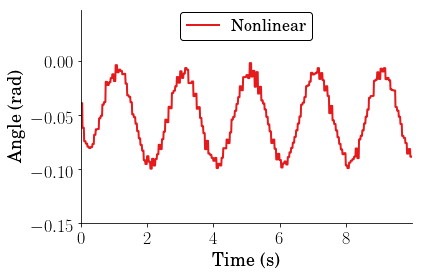

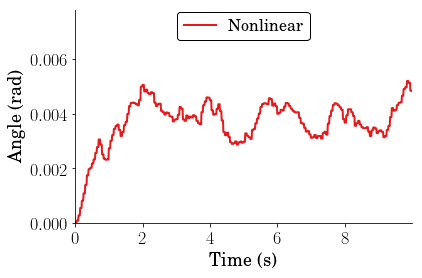

In [20]:
plot.generate_plot(t,
              np.vstack((mpc_input)),
              ['Nonlinear'],
              'Time (s)',
              'Angle (rad)',
              filename='xx__Rotation',
              folder='Simulations/',
              num_col=2,legend_loc='upper center',ymax=0.5,showplot=True)

plot.generate_plot(t,
              np.vstack((predicted_cost)),
              ['Nonlinear'],
              'Time (s)',
              'Angle (rad)',
              filename='xx__Rotation',
              folder='Simulations/',
              num_col=2,legend_loc='upper center',ymax=0.5,showplot=True)

/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1852: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'
/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


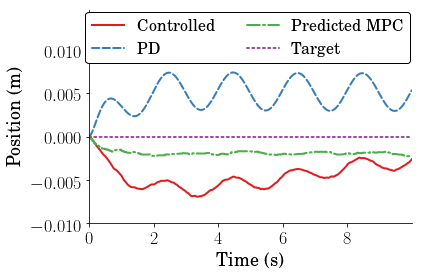

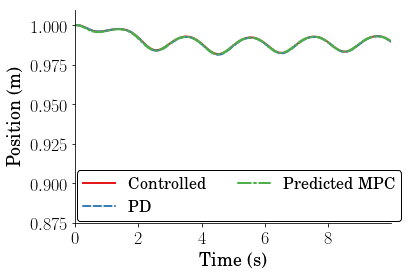

In [21]:
x,y = get_xy_coords(n,lin_response, L)
x_mpc,y_mpc = get_xy_coords(n,mpc_response, L)
x_uncontrolled,y_uncontrolled = get_xy_coords(n,uncontrolled_response, L)
xdot_mpc,ydot_mpc = get_xy_deriv(n,mpc_response,L)

x_tip_mpc = x_mpc[:,-1]
y_tip_mpc = y_mpc[:,-1]

predicted_x, predicted_y = get_xy_coords(n,predicted_states,L)

xdot_tip_mpc = xdot_mpc[:,-1]
ydot_tip_mpc = ydot_mpc[:,-1]

trig_tol = 0.001

    
plot.generate_plot(t,
              np.vstack((y_mpc[:,-1],y[:,-1],predicted_y[:,-1],np.ones_like(t) * .0)),
              ['Controlled','PD','Predicted MPC','Target'],
              'Time (s)',
              'Position (m)',
              filename='x_Tip',
              folder='Simulations/',
              num_col=2,legend_loc='best',ymax=0.5,ymin=0.01,showplot=True)

plot.generate_plot(t,
              np.vstack((x_mpc[:,-1],x[:,-1],predicted_x[:,-1])),
              ['Controlled','PD','Predicted MPC'],
              'Time (s)',
              'Position (m)',
              filename='y_Tip',
              folder='Simulations/',
              num_col=2,legend_loc='best',ymax=0.5,showplot=True)


In [22]:
%%capture
fps = int(np.round(1 / dt))

FFMpegWriter = writers['ffmpeg']

def update_lines(num, x,y, lines):
    lines.set_data(x[num],y[num])
    #lines.set_3d_properties(z[num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = plt.gca()

lines, = ax.plot([], [], 'o-', lw=2)

plt.axes().set_aspect('equal')
#data = np.array([x,y])

# Setting the axes properties
ax.set_xlim([-1, 1.0])
ax.set_xlabel('X')

ax.set_ylim([-1, 1])
ax.set_ylabel('Y')

ax.set_title('Response')


In [23]:
# Create the animation
anim = animation.FuncAnimation(
                    fig, # Use the predefined figure
                    update_lines, # Call the update function
                    frames=fps * int(np.amax(t)), # Use a number of frames based on the framerate and length of the time array
                    interval=fps,
                    fargs = (x,y,lines),
                    blit=False)

# We can also add some metadata to the video.
metadata = dict(title='Input Shaping Animation', artist='CRAWLAB',
                comment='Shows a point-to-poitn move of a planar crane with and without input shaping.')

# Change the video bitrate as you like and add some metadata.
writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

anim.save(
    'animation.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})

/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [24]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="animation.mp4" type="video/mp4">
</video></div>""")

In [25]:
x_uncontrolled,y_uncontrolled = get_xy_coords(n,uncontrolled_response, L)

# Create the animation
anim_uncontrolled = animation.FuncAnimation(
                    fig, # Use the predefined figure
                    update_lines, # Call the update function
                    frames=fps * int(np.amax(t)), # Use a number of frames based on the framerate and length of the time array
                    interval=fps,
                    fargs = (x_uncontrolled,y_uncontrolled,lines),
                    blit=False)

# We can also add some metadata to the video.
metadata = dict(title='Input Shaping Animation', artist='CRAWLAB',
                comment='Shows a point-to-poitn move of a planar crane with and without input shaping.')

# Change the video bitrate as you like and add some metadata.
writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

anim_uncontrolled.save(
    'animation-uncontrolled.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})

/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [26]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="animation-uncontrolled.mp4" type="video/mp4">
</video></div>""")

In [27]:
x_mpc,y_mpc = get_xy_coords(n,mpc_response, L)

# Create the animation
anim_mpc = animation.FuncAnimation(
                    fig, # Use the predefined figure
                    update_lines, # Call the update function
                    frames=fps * int(np.amax(t)), # Use a number of frames based on the framerate and length of the time array
                    interval=fps,
                    fargs = (x_mpc,y_mpc,lines),
                    blit=False)

# We can also add some metadata to the video.
metadata = dict(title='Input Shaping Animation', artist='CRAWLAB',
                comment='Shows a point-to-poitn move of a planar crane with and without input shaping.')

# Change the video bitrate as you like and add some metadata.
writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

anim_mpc.save(
    'animation-mpc.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})

/home/dnewman/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [28]:
# This cell will just improve the styling of the notebook
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://raw.githubusercontent.com/danielnewman09/Thesis-Notebooks/master/Styling/IpythonNotebook.css")
HTML(response.read().decode("utf-8"))